In [520]:
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial



In [510]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat2.fits'

t = Table.read(path_amas)
#display(t)


In [511]:
def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

In [512]:
t_halo = table(path_halo)
t_amas = table(path_amas)

In [513]:
#print(t_amas["mt_cross"][0])
t_amas_match = t_amas[t_amas["mt_cross"] !='']
#print(t_amas_match)

In [514]:
M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M

In [515]:
#print(t_amas_match)

In [516]:
def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]

In [517]:
Mp, zp = 10**14.3, 0.5

In [518]:
list_coupures = np.linspace(20, 80, 13)
print(list_coupures)

[20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80.]


In [540]:
# renvoie le ln de la probabilité d'observer nos données (tend vers 0 idéalement)
#X est le catalogue
def _ln_L(params, X):
    A, B, C, D, E, F = params
    #A, B, D = params
    C, E, F = 0, 0, 0  # on fixe 3 paramètr
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
    sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    sigma = np.clip(sigma, 1e-5, None)

    #print("sigma max/min :", max(sigma), min(sigma))
    
    #log-Vraissemblance
    ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-mean_alpha)/sigma)**2)
    #print(-ln_L)
    return -ln_L

def parametres_incertitudes(coupure, P0 = [None]):
    if coupure != 0:
        X = tableau_coupure_n200(coupure) 
    else:
        X = t_amas_match
    if P0[0] == None:
        p0 = np.random.uniform(1e-3, 0.2, 6)
    else:
        p0 = P0
    bounds = [
    (0, np.inf),  # A
    (0, np.inf),  # B
    (-2, 2),  # C
    (0, np.inf),     # D (éviter sigma proche de 0)
    (-2, 2),       # E
    (-2, 2)        # F
    ]
    #bounds = [(0, np.inf), (0, np.inf), (1e-5, np.inf)]
    res = scipy.optimize.minimize(_ln_L, p0, args=(X,), method='L-BFGS-B', bounds = bounds)
    if not res.success:
        raise RuntimeError(f"Optimisation échouée : {res.message}")
    try:
        cov = res.hess_inv.todense()
        incertitudes = np.sqrt(np.diag(cov))
        L = _ln_L(tuple(res.x), X)
        #print(np.round(cov, 3))
    except AttributeError:
        print("Impossible d'extraire le Hessien inverse")
        return [None], [None], [None]
    return res.x, incertitudes, L

Coupure en cours : 20.0
[3.71223673 0.31133999 0.07098342 0.3200422  0.05153586 0.0534414 ]
[0.17469579 0.33150254 1.         0.06237027 1.         1.        ]
Coupure en cours : 25.0
[3.84358669e+00 3.11311196e-01 4.72482877e-03 3.07397119e-01
 3.49928533e-03 1.40181953e-01]
[0.14711218 0.6864233  1.         1.27352651 1.         1.        ]
Coupure en cours : 30.0
[3.94640229 0.30571353 0.06084439 0.3000182  0.1975735  0.08153079]
[0.04513574 0.22552651 1.         0.03665949 1.         1.        ]
Coupure en cours : 35.0
[4.03714181 0.29507023 0.00441489 0.29074237 0.01749993 0.02450935]
[0.0412548  0.1731719  1.         0.02274987 1.         1.        ]
Coupure en cours : 40.0
[4.1249835  0.2878489  0.10533593 0.27728589 0.04094988 0.01294659]
[0.03077874 0.26724606 1.         0.12657063 1.         1.        ]
Coupure en cours : 45.0
[4.19692239 0.26806487 0.08704066 0.26992963 0.12618994 0.01361304]
[0.00814159 0.01333604 1.         0.00617126 1.         1.        ]
Coupure en cour

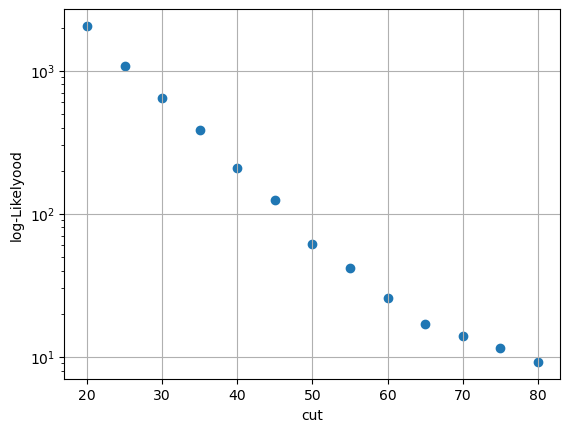

In [545]:
list_A, list_B, list_C, list_D, list_E, list_F  = [], [], [], [], [], []
list_err_A, list_err_B, list_err_C, list_err_D, list_err_E, list_err_F  = [], [], [], [], [], []
L = []
for coupure in list_coupures:
    print("Coupure en cours :", coupure)
    parametres, incertitudes, L_ = parametres_incertitudes(coupure)
    L.append(L_)
    print(parametres)
    print(incertitudes)
    list_A.append(parametres[0]) # récupération des paramètres et de leurs incertitudes
    list_B.append(parametres[1])
    list_C.append(parametres[2])
    list_D.append(parametres[2])
    list_E.append(parametres[4])
    list_F.append(parametres[5])
    list_err_A.append(incertitudes[0])
    list_err_B.append(incertitudes[1])
    list_err_C.append(incertitudes[2])
    list_err_D.append(incertitudes[2])
    list_err_E.append(incertitudes[4])
    list_err_F.append(incertitudes[5])
plt.scatter(list_coupures, L)
plt.xlabel('cut')
plt.ylabel('log-Likelyood')
plt.yscale('log')
plt.grid()
plt.show()

In [544]:
print(L)

[2052.5320389470144, 1079.3500935651425, 641.8561183138474, 386.33836862919304, 208.43575040674034, 125.41837374424762, 60.89665561687076, 41.60887186763529, 25.63961071337752, 16.838657226161786, 13.852695279084486, 11.546425177381963, 9.184979157660209]


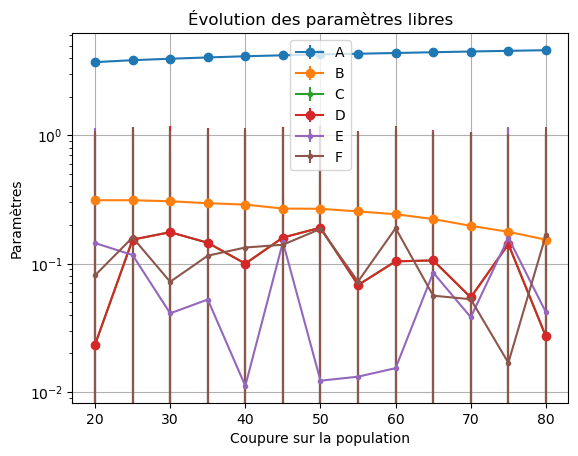

In [543]:
plt.clf()

plt.errorbar(list_coupures, list_A, yerr = list_err_A, label = 'A', marker = 'o')
plt.errorbar(list_coupures, list_B, yerr = list_err_B, label = 'B', marker = 'o')
plt.errorbar(list_coupures, list_C, yerr = list_err_C, label = 'C', marker = '.')
plt.errorbar(list_coupures, list_D, yerr = list_err_D, label = 'D', marker = 'o')
plt.errorbar(list_coupures, list_E, yerr = list_err_E, label = 'E', marker = '.')
plt.errorbar(list_coupures, list_F, yerr = list_err_F, label = 'F', marker = '.')

plt.grid()
plt.xlabel("Coupure sur la population")
plt.ylabel("Paramètres")
plt.title('Évolution des paramètres libres')
plt.yscale('log')
plt.legend()
plt.show()


In [558]:
P = [[], [], [], [], [], []] #listes des paramètres

In [559]:
#MC
N = 100
for i in range(N):
    if (100*i/N) % 5 == 0:
        print("progression : "+str(round(100*i/N, 2))+" %")
    parametres, incertitudes, L_ = parametres_incertitudes(coupure = 20)
    #print(parametres)
    if parametres[0] != None:
        P[0].append(parametres[0]) # récupération des paramètres et de leurs incertitudes
        P[1].append(parametres[1])
        P[2].append(parametres[2])
        P[3].append(parametres[3])
        P[4].append(parametres[4])
        P[5].append(parametres[5])

progression : 0.0 %
progression : 5.0 %
progression : 10.0 %
progression : 15.0 %
progression : 20.0 %
progression : 25.0 %
progression : 30.0 %
progression : 35.0 %
progression : 40.0 %
progression : 45.0 %
progression : 50.0 %
progression : 55.0 %
progression : 60.0 %
progression : 65.0 %
progression : 70.0 %
progression : 75.0 %
progression : 80.0 %
progression : 85.0 %
progression : 90.0 %
progression : 95.0 %


In [562]:
# filtrage des valeurs aberrantes
std_A = np.std(np.array( P[0]))
std_B = np.std(np.array( P[1]))
std_C = np.std(np.array( P[2]))
std_D = np.std(np.array( P[3]))
std_E = np.std(np.array( P[4]))
std_F = np.std(np.array( P[5]))

mean_A = np.array( P[0]).mean()
mean_B = np.array( P[1]).mean()
mean_C = np.array( P[2]).mean()
mean_D = np.array( P[3]).mean()
mean_E = np.array( P[4]).mean()
mean_F = np.array( P[5]).mean()

table_param = Table()
table_param["A"] =  P[0]
table_param["B"] =  P[1]
table_param["C"] =  P[2]
table_param["D"] =  P[3]
table_param["E"] =  P[4]
table_param["F"] =  P[5]

# Filtre des données bruitées (écartées de la moyenne à plus de 10 écarts types)
mask = (
    (abs(table_param["A"] - mean_A) / std_A < 5) &
    (abs(table_param["B"] - mean_B) / std_B < 5) &
    (abs(table_param["C"] - mean_C) / std_C < 5) &
    (abs(table_param["D"] - mean_D) / std_D < 5) &
    (abs(table_param["E"] - mean_E) / std_E < 5) &
    (abs(table_param["F"] - mean_F) / std_F < 5)
    )
table_param = table_param[mask]

# Recalcul de l'écart type une fois les données nettoyées
std_A = np.std(table_param["A"])
std_B = np.std(table_param["B"])
std_C = np.std(table_param["C"])
std_D = np.std(table_param["D"])
std_E = np.std(table_param["E"])
std_F = np.std(table_param["F"])



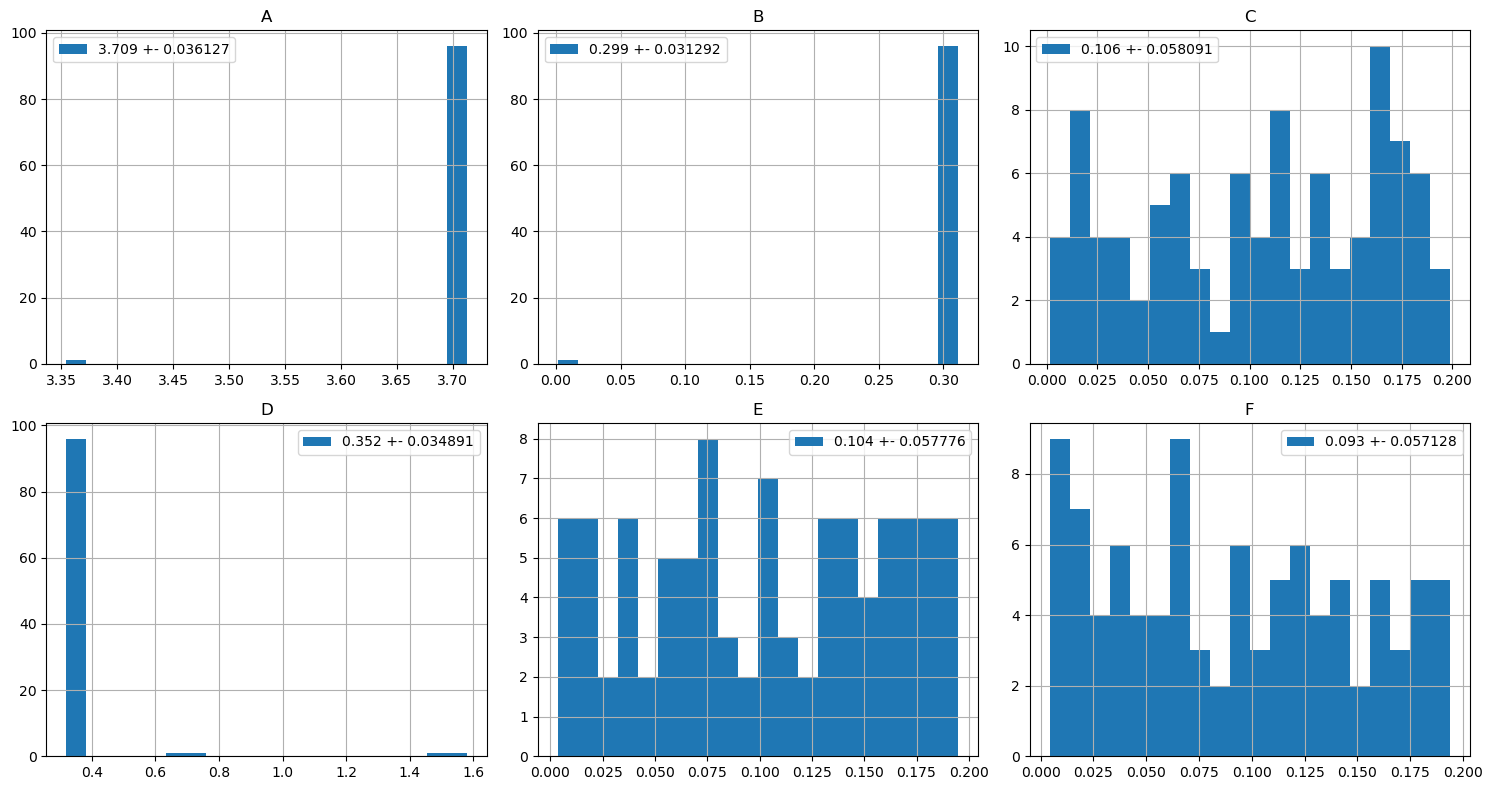

In [563]:
bins = max(len(list_E)//10, 20)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)

A = axes[0, 0]
A.hist(table_param["A"], bins = bins, label = str(round(mean_A, 3)) + " +- " + str(round(std_A, 6)))
A.set_title("A")
A.grid(True)
#A.set_xlim((mean_A-5*std_A, mean_A+5*std_A))
A.legend()
B = axes[0, 1]
B.hist(table_param["B"], bins = bins, label = str(round(mean_B, 3)) + " +- " + str(round(std_B, 6)))
B.set_title("B")
B.grid(True)
#B.set_xlim((mean_B-5*std_B, mean_B+5*std_B))
B.legend()
C = axes[0, 2]
C.hist(table_param["C"], bins = bins, label = str(round(mean_C, 3)) + " +- " + str(round(std_C, 6)))
C.set_title("C")
C.grid(True)
#C.set_xlim((mean_C-5*std_C, mean_C+5*std_C))
C.legend()

D = axes[1, 0]
D.hist(P[3], bins = bins, label = str(round(mean_D, 3)) + " +- " + str(round(std_D, 6)))
D.set_title("D")
D.grid(True)
#D.set_xlim((mean_D-5*std_D, mean_D+5*std_D))
D.legend()
E = axes[1, 1]
E.hist(table_param["E"], bins = bins, label = str(round(mean_E, 3)) + " +- " + str(round(std_E, 6)))
E.set_title("E")
E.grid(True)
#E.set_xlim((mean_E-5*std_E, mean_E+5*std_E))
E.legend()
F = axes[1, 2]
F.hist(table_param["F"], bins = bins, label = str(round(mean_F, 3)) + " +- " + str(round(std_F, 6)))
F.set_title("F")
F.grid(True)
#F.set_xlim((mean_F-5*std_F, mean_F+5*std_F))
F.legend()

# Ajustement de l'espacement
fig.tight_layout()
plt.show()
plt.show()